<a href="https://colab.research.google.com/github/mparker2103/PatternFlow/blob/topic-recognition/recognition/s4436238_UNet/Improved_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, Flatten, Dense, Dropout, UpSampling2D, Reshape
from tensorflow.keras.models import Model
from keras import backend as k
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os

from google.colab import drive

In [2]:
depth = 16
n = 256
batch_size = 20
epochs = 20

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read single image from folders; this caches the folder to get Google Colab to iterate through files quicker
train = imread('/content/drive/MyDrive/Colab_Notebooks/Data/ISIC2018_Task1-2_Training_Input_x2/Sample_Set/ISIC_0000000.jpg')
test = imread('/content/drive/MyDrive/Colab_Notebooks/Data/ISIC2018_Task1_Training_GroundTruth_x2/Sample_Set/ISIC_0000000_segmentation.png')

In [5]:
path = '/content/drive/MyDrive/Colab_Notebooks/Data/ISIC2018_Task1-2_Training_Input_x2/Sample_Set/'
train = []
for img in os.listdir(path):
    itm = imread(path + img)
    itm = resize(itm, (n, n, 3))
    train.append(itm)

train = np.array(train)

In [6]:
path = '/content/drive/MyDrive/Colab_Notebooks/Data/ISIC2018_Task1_Training_GroundTruth_x2/Sample_Set/'
test = []
for img in os.listdir(path):
    itm = imread(path + img)
    itm = resize(itm, (n, n))
    test.append(itm)

test = np.array(test)

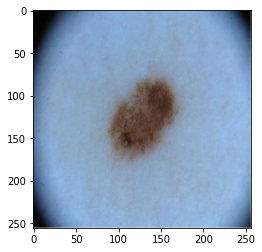

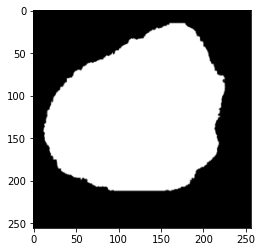

In [7]:
# Check images loaded correctly
plt.imshow(train[0], cmap='gray')
plt.show()
plt.imshow(test[0], cmap='gray')
plt.show()

In [8]:
# Convert arrays to tensors and normalise
train = tf.convert_to_tensor(train)

In [9]:
test = tf.convert_to_tensor(test)

In [10]:
train = tf.cast(train, tf.float32) / 255.
test = tf.cast(test, tf.float32) / 255.

print(train.shape)
print(test.shape)

(92, 256, 256, 3)
(92, 256, 256)


In [11]:
# create the downsampling network
downsample_inputs = Input(shape=(n,n,3), name='Downsample_Inputs')

# Downsample 1
net1 = Conv2D(depth, (3,3), padding='same', activation='relu', name='Net1')(downsample_inputs)
pool1 = MaxPooling2D(pool_size=(2,2), name='Pool1')(net1)

# Downsample 2
net2 = Conv2D(depth*2, (3,3), padding='same', activation='relu', name='Net2')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2), name='Pool2')(net2)

# Downsample 3
net3 = Conv2D(depth*4, (3,3), padding='same', activation='relu', name='Net3')(pool2)
pool3 = MaxPooling2D(pool_size=(2,2), name='Pool3')(net3)

# Downsample 4
net4 = Conv2D(depth*8, (3,3), padding='same', activation='relu', name='Net4')(pool3)
pool4 = MaxPooling2D(pool_size=(2,2), name='Pool4')(net4)

# Downsample 5
net5 = Conv2D(depth*16, (3,3), padding='same', activation='relu', name='Net5')(pool4)
pool5 = MaxPooling2D(pool_size=(2,2), name='Pool5')(net5)

# Middle layer

#Model
downsample = Model(downsample_inputs, pool5, name='Downsample_Model')
downsample.summary()

Model: "Downsample_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Downsample_Inputs (InputLaye [(None, 256, 256, 3)]     0         
_________________________________________________________________
Net1 (Conv2D)                (None, 256, 256, 16)      448       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 128, 128, 16)      0         
_________________________________________________________________
Net2 (Conv2D)                (None, 128, 128, 32)      4640      
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
Net3 (Conv2D)                (None, 64, 64, 64)        18496     
_________________________________________________________________
Pool3 (MaxPooling2D)         (None, 32, 32, 64)   

In [43]:
# create the network
upsample_inputs = Input(shape=(8,8,n), name='Upsample_Inputs')

# Upsample 5
up5 = UpSampling2D(size=(2,2), interpolation='bilinear', name='Up5')(upsample_inputs)
net5 = Conv2D(depth*16, (3,3), padding='same', activation='relu', name='Net5Up')(up5)

# Upsample 4
up4 = UpSampling2D(size=(2,2), interpolation='bilinear', name='Up4')(net5)
net4 = Conv2D(depth*8, (3,3), padding='same', activation='relu', name='Net4Up')(up4)

# Upsample 3
up3 = UpSampling2D(size=(2,2), interpolation='bilinear', name='Up3')(net4)
net3 = Conv2D(depth*4, (3,3), padding='same', activation='relu', name='Net3Up')(up3)

# Upsample 2
up2 = UpSampling2D(size=(2,2), interpolation='bilinear', name='Up2')(net3)
net2 = Conv2D(depth*2, (3,3), padding='same', activation='relu', name='Net2Up')(up2)

# Upsample 1
up1 = UpSampling2D(size=(2,2), interpolation='bilinear', name='Up1')(net2)
net1 = Conv2D(depth, (3,3), padding='same', activation='relu', name='Net1Up')(up1)

# Reshape into two dimensions
dense = Dense(1, activation='relu', name='Dense1')(net1)
dense = Reshape(test.shape[1:], name='Dense2')(dense)

# Model
upsample = Model(upsample_inputs, dense, name='Upsample_Model')
upsample.summary()

Model: "Upsample_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsample_Inputs (InputLayer) [(None, 8, 8, 256)]       0         
_________________________________________________________________
Up5 (UpSampling2D)           (None, 16, 16, 256)       0         
_________________________________________________________________
Net5Up (Conv2D)              (None, 16, 16, 256)       590080    
_________________________________________________________________
Up4 (UpSampling2D)           (None, 32, 32, 256)       0         
_________________________________________________________________
Net4Up (Conv2D)              (None, 32, 32, 128)       295040    
_________________________________________________________________
Up3 (UpSampling2D)           (None, 64, 64, 128)       0         
_________________________________________________________________
Net3Up (Conv2D)              (None, 64, 64, 64)     

In [44]:
# Map an input to its reconstruction to create model
model_downsample_output = downsample(downsample_inputs)
model_upsample_output = upsample(model_downsample_output)

model = Model(downsample_inputs, model_upsample_output, name='UNet')
model.summary()

Model: "UNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Downsample_Inputs (InputLaye [(None, 256, 256, 3)]     0         
_________________________________________________________________
Downsample_Model (Functional (None, 8, 8, 256)         392608    
_________________________________________________________________
Upsample_Model (Functional)  (None, 256, 256)          982017    
Total params: 1,374,625
Trainable params: 1,374,625
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Define dice coefficient metric
def dice_coefficient (y_true, y_pred):
    y_true_flat = k.flatten(y_true)
    y_pred_flat = k.flatten(y_pred) 
    
    intersection = k.sum(y_true_flat * y_pred_flat)
    coeff = (2.0 * intersection) / ( k.sum(k.square(y_true_flat)) + k.sum(k.square(y_pred_flat)) )
    return coeff
#TODO update this

In [50]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])

In [51]:
model_hist = model.fit(train, train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(test, test))

Epoch 1/20


ValueError: ignored